# Isolation Forest

## Dataset

In [1]:
import pandas as pd

# Load train and test
train_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/train_df_feature.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/test_df_feature.csv')

In [2]:
# Preview
test_df.head()

,mean_vx,std_vx,min_vx,max_vx,mean_vy,std_vy,min_vy,max_vy,mean_v,std_v,...,sum_of_angles,largest_deviation,num_sharp_angles,a_beg_time,pause_ratio,user,session,action_id,action_label,is_illegal
0,121.240185,160.069331,-32.051282,440.170940,132.380406,208.956586,-43.010753,495.412845,213.580897,236.414890,...,6.859695,26.545419,0,0.343,0.0,user12,session_0170625567,1,PC,1.0
1,-224.261880,583.953910,-1872.727275,10.256410,-51.286442,123.484384,-400.000000,0.000000,235.169883,594.869211,...,15.759278,12.443537,1,0.640,0.0,user12,session_0170625567,2,PC,1.0
2,4.600155,293.729259,-596.330274,605.504586,-286.606112,613.320825,-1935.779813,266.055045,408.875310,614.348856,...,9.773561,93.263003,0,0.109,0.0,user12,session_0170625567,3,PC,1.0
3,-50.656994,117.275308,-321.100917,64.220183,253.009324,386.689017,0.000000,1247.706420,286.897522,384.124400,...,4.714032,51.723514,1,0.749,0.0,user12,session_0170625567,4,PC,1.0
4,32.435856,491.011053,-844.036696,1537.634410,-17.859301,227.799483,-605.504587,526.881721,289.214885,459.031860,...,13.985511,95.238799,1,0.093,0.0,user12,session_0170625567,5,MM,1.0


## Setup & Preprocessing

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

# Lock feature set (exclude IDs/labels)
EXCLUDED_COLS = ['user', 'session', 'action_id', 'action_label', 'is_illegal']
feature_columns = [c for c in train_df.columns if c not in EXCLUDED_COLS]

# Ensure features are numeric float32 BEFORE scaling (prevents dtype assignment warnings)
for df in (train_df, test_df):
    df[feature_columns] = (
        df[feature_columns]
        .apply(pd.to_numeric, errors='coerce')  # coerce any stray non-numerics to NaN
        .astype('float32')
        .fillna(0.0)                            # simple, consistent NaN policy; change if you prefer imputation
    )

# Per-user scaling: fit on train(user), transform train(user) & test(user)
scalers = {}            # user_id -> fitted scaler
train_by_user = {}      # user_id -> scaled train df
test_by_user  = {}      # user_id -> scaled test df (may be missing)

for user_id in train_df['user'].unique():
    utrain = train_df[train_df['user'] == user_id].copy()
    utest  = test_df[test_df['user'] == user_id].copy()

    if utrain.empty:
        continue

    scaler = StandardScaler()

    # ---- Train scaling ----
    Xtr = utrain[feature_columns].to_numpy(copy=True)          # already float32
    Xtr_scaled = scaler.fit_transform(Xtr).astype('float32')
    utrain_scaled_block = pd.DataFrame(
        Xtr_scaled, index=utrain.index, columns=feature_columns
    )
    utrain.loc[:, feature_columns] = utrain_scaled_block

    # ---- Test scaling (if present) ----
    if not utest.empty:
        Xte = utest[feature_columns].to_numpy(copy=True)       # already float32
        Xte_scaled = scaler.transform(Xte).astype('float32')
        utest_scaled_block = pd.DataFrame(
            Xte_scaled, index=utest.index, columns=feature_columns
        )
        utest.loc[:, feature_columns] = utest_scaled_block

    scalers[user_id] = scaler
    train_by_user[user_id] = utrain
    if not utest.empty:
        test_by_user[user_id] = utest

## Train per-user Isolation Forest & score

In [4]:
def train_models(train_by_user, feature_columns):
    models = {}
    for uid, utrain in tqdm(train_by_user.items(), desc="Training per-user Isolation Forest"):
        Xtr = utrain[feature_columns]
        model = IsolationForest(
            n_estimators=500,
            max_samples='auto',   # you can try 256 or 512 for stability
            max_features=0.5,
            contamination='auto', # not used since we rely on score_samples
            random_state=42,
            n_jobs=-1
        )
        model.fit(Xtr)
        models[uid] = model
    return models

def score_train_test(models, train_by_user, test_by_user, feature_columns):
    """
    Returns:
      train_scores_by_user: uid -> np.array of train scores (higher = more anomalous)
      combined_test_df: all users' test with columns: user, session, ..., anomaly_score
    """
    train_scores_by_user = {}
    test_rows = []
    for uid, model in tqdm(models.items(), desc="Scoring train & test"):
        # Train scores (for threshold selection)
        utrain = train_by_user[uid]
        s_tr = -model.score_samples(utrain[feature_columns])  # higher = more anomalous
        train_scores_by_user[uid] = s_tr

        # Test scores (for evaluation)
        if uid in test_by_user:
            utest = test_by_user[uid].copy()
            s_te = -model.score_samples(utest[feature_columns])
            utest['anomaly_score'] = s_te
            test_rows.append(utest)

    combined_test_df = pd.concat(test_rows, ignore_index=True) if len(test_rows) else pd.DataFrame()
    return train_scores_by_user, combined_test_df

models = train_models(train_by_user, feature_columns)
train_scores_by_user, test_scored_df = score_train_test(models, train_by_user, test_by_user, feature_columns)

# Safety check
if test_scored_df.empty:
    print("No test data found for the trained users. Evaluation will be empty.")

Scoring train & test: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


## Threshold rules (train-only)

In [5]:
from scipy.stats import genpareto

def iqr_threshold(train_scores: np.ndarray, k: float = 3.0) -> float:
    q1, q3 = np.percentile(train_scores, [25, 75])
    return q3 + k * (q3 - q1)

def mad_threshold(train_scores: np.ndarray, c: float = 3.5) -> float:
    m = np.median(train_scores)
    mad = np.median(np.abs(train_scores - m))
    return m + c * mad

def evt_threshold(train_scores: np.ndarray, u_pct: float = 95.0,
                  target_tail_p: float = 0.02, min_exceedances: int = 30):
    """
    Peaks-over-threshold using GPD on train scores.
    Returns threshold or None if not enough exceedances.
    """
    u = np.percentile(train_scores, u_pct)
    exc = train_scores[train_scores > u] - u
    if exc.size < min_exceedances:
        return None
    # Fit GPD to exceedances (loc forced to 0 for exceedances)
    xi, loc, sigma = genpareto.fit(exc, floc=0.0)
    q = genpareto.ppf(1 - target_tail_p, xi, loc=0.0, scale=sigma)
    return float(u + q)

## Evaluation helpers

In [6]:
def eval_action_level_full(test_df_with_preds: pd.DataFrame, sort_by='recall') -> pd.DataFrame:
    """Compute per-user action-level metrics and print both table + macro averages."""
    results = []
    skipped_users = 0

    for uid, g in test_df_with_preds.groupby('user'):
        y_true = g['is_illegal']
        if 'is_illegal_pred' not in g.columns:
            continue
        y_pred = g['is_illegal_pred']
        scores = g['anomaly_score']

        if y_true.nunique() < 2:
            skipped_users += 1
            continue

        auc = roc_auc_score(y_true, scores)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        results.append({
            'user': uid,
            'auc': auc,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
        })

    res_df = pd.DataFrame(results)

    if not res_df.empty:
        print(f"\n📊 Action-Level Evaluation ({sort_by} order):")
        print(res_df.sort_values(sort_by, ascending=False).to_string(index=False))

        print("\n📈 Average Summary:")
        print(f"Average Recall:     {res_df['recall'].mean():.4f}")
        print(f"Average Precision:  {res_df['precision'].mean():.4f}")
        print(f"Average F1 Score:   {res_df['f1'].mean():.4f}")
        print(f"Average AUC:        {res_df['auc'].mean():.4f}")
    else:
        print("\nNo users with both classes in test — cannot compute metrics.")

    return res_df

def apply_thresholds_and_eval(method_name: str, thresholds_by_user: dict, test_scored_df: pd.DataFrame) -> pd.DataFrame:
    if test_scored_df.empty:
        print(f"\n[{method_name}] Skipped: no test data.")
        return pd.DataFrame()

    df = test_scored_df.copy()
    df['thr'] = df['user'].map(thresholds_by_user)
    df['is_illegal_pred'] = (df['anomaly_score'] > df['thr']).astype(int)

    print(f"\n=== {method_name} — Action-level Evaluation ===")
    return eval_action_level_full(df, sort_by='recall')

## IQR thresholds

In [7]:
iqr_thresholds = {}
for uid, scores in train_scores_by_user.items():
    iqr_thresholds[uid] = iqr_threshold(scores, k=1.0)

iqr_metrics = apply_thresholds_and_eval("IQR rule (Q3 + k*IQR, k=1.0)", iqr_thresholds, test_scored_df)


=== IQR rule (Q3 + k*IQR, k=1.0) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.884888 0.522599   0.918874 0.666267 555  49  801  507
user29 0.633698 0.310987   0.406326 0.352321 167 244 1615  370
user23 0.639927 0.261734   0.824561 0.397343 329  70  723  928
 user7 0.756297 0.223022   0.567766 0.320248 155 118 1212  540
user35 0.625049 0.216510   0.868976 0.346651 577  87  907 2088
user12 0.586922 0.200389   0.620482 0.302941 309 189 2013 1233
user15 0.571237 0.178263   0.842412 0.294258 433  81  805 1996
user16 0.524787 0.176672   0.457778 0.254950 206 244 2372  960
user21 0.511552 0.148590   0.416413 0.219025 137 192 1035  785
user20 0.441285 0.048558   0.271186 0.082368  32  86  737  627

📈 Average Summary:
Average Recall:     0.2287
Average Precision:  0.6195
Average F1 Score:   0.3236
Average AUC:        0.6176


## EVT thresholds

In [8]:
evt_thresholds = {}
evt_skipped = []
for uid, scores in train_scores_by_user.items():
    thr = evt_threshold(scores, u_pct=95.0, target_tail_p=0.02, min_exceedances=30)
    if thr is None:
        evt_skipped.append(uid)
    else:
        evt_thresholds[uid] = thr

if evt_skipped:
    print(f"\n[EVT] Users without enough exceedances (skipped): {len(evt_skipped)}")

evt_metrics = apply_thresholds_and_eval("EVT rule (u=95th, tail_p=2%)", evt_thresholds, test_scored_df)


=== EVT rule (u=95th, tail_p=2%) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.884888 0.022599   1.000000 0.044199  24   0  850 1038
user16 0.524787 0.012864   0.833333 0.025338  15   3 2613 1151
user12 0.586922 0.009728   0.882353 0.019243  15   2 2200 1527
user35 0.625049 0.005629   0.937500 0.011190  15   1  993 2650
user15 0.571237 0.002882   0.875000 0.005745   7   1  885 2422
 user7 0.756297 0.001439   1.000000 0.002874   1   0 1330  694
user21 0.511552 0.001085   0.500000 0.002165   1   1 1226  921
user23 0.639927 0.000796   1.000000 0.001590   1   0  793 1256
user20 0.441285 0.000000   0.000000 0.000000   0   1  822  659
user29 0.633698 0.000000   0.000000 0.000000   0   3 1856  537

📈 Average Summary:
Average Recall:     0.0057
Average Precision:  0.7028
Average F1 Score:   0.0112
Average AUC:        0.6176


## MAD thresholds

In [9]:
mad_thresholds = {}
for uid, scores in train_scores_by_user.items():
    mad_thresholds[uid] = mad_threshold(scores, c=3.5)   # try 3.0–4.5

mad_metrics = apply_thresholds_and_eval("MAD rule (median + c*MAD, c=3.5)", mad_thresholds, test_scored_df)


=== MAD rule (median + c*MAD, c=3.5) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.884888 0.504708   0.917808 0.651276 536  48  802  526
user29 0.633698 0.310987   0.407317 0.352693 167 243 1616  370
user23 0.639927 0.275259   0.802784 0.409953 346  85  708  911
user35 0.625049 0.231520   0.864146 0.365197 617  97  897 2048
 user7 0.756297 0.217266   0.563433 0.313603 151 117 1213  544
user12 0.586922 0.209468   0.617591 0.312833 323 200 2002 1219
user16 0.524787 0.191252   0.447791 0.268029 223 275 2341  943
user15 0.571237 0.190202   0.833935 0.309755 462  92  794 1967
user21 0.511552 0.152928   0.419643 0.224165 141 195 1032  781
user20 0.441285 0.048558   0.271186 0.082368  32  86  737  627

📈 Average Summary:
Average Recall:     0.2332
Average Precision:  0.6146
Average F1 Score:   0.3290
Average AUC:        0.6176


## Session level evaluation

In [ ]:
def session_level_eval_both(test_scored_df: pd.DataFrame, thresholds_by_user: dict,
                            method_name: str, sort_by='recall'):
    """
    Evaluate session-level performance using BOTH mean and max aggregation of action scores.

    Args
    ----
    test_scored_df : DataFrame
        Must include columns ['user','session','is_illegal','anomaly_score'].
    thresholds_by_user : dict
        user_id -> threshold.
    method_name : str
        Name of the thresholding method (e.g., 'IQR', 'EVT', 'MAD').
    sort_by : str
        Column to sort the per-user table by when printing.

    Returns
    -------
    results : dict
        {'mean': DataFrame, 'max': DataFrame} with per-user metrics tables.
        Each DataFrame includes 'method' and 'agg' columns.
    """
    assert {'user','session','is_illegal','anomaly_score'}.issubset(test_scored_df.columns)

    def _eval_for_agg(agg_name, agg_func_name):
        rows = []
        skipped = 0

        for uid, g in test_scored_df.groupby('user'):
            if uid not in thresholds_by_user:
                skipped += 1
                continue
            thr = thresholds_by_user[uid]

            # Aggregate scores & labels per session
            sess_scores = g.groupby('session')['anomaly_score'].agg(agg_func_name)
            sess_labels = g.groupby('session')['is_illegal'].max()
            if sess_labels.nunique() < 2:
                skipped += 1
                continue

            # Predict with SAME threshold
            sess_preds = (sess_scores > thr).astype(int)

            auc = roc_auc_score(sess_labels, sess_scores)
            recall = recall_score(sess_labels, sess_preds)
            precision = precision_score(sess_labels, sess_preds, zero_division=0)
            f1 = f1_score(sess_labels, sess_preds)
            tn, fp, fn, tp = confusion_matrix(sess_labels, sess_preds).ravel()

            rows.append({
                'method': method_name,
                'agg': agg_name,
                'user': uid,
                'auc': auc,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
                'sessions': len(sess_labels)
            })

        res = pd.DataFrame(rows)
        if not res.empty:
            print(f"\n🧪 [{method_name}] Session-Level ({agg_name.upper()} of action scores) — sorted by {sort_by}:")
            print(res.sort_values(sort_by, ascending=False).to_string(index=False))
            print("\n📈 Averages:")
            print(f"Avg Recall:    {res['recall'].mean():.4f}")
            print(f"Avg Precision: {res['precision'].mean():.4f}")
            print(f"Avg F1:        {res['f1'].mean():.4f}")
            print(f"Avg AUC:       {res['auc'].mean():.4f}")
        else:
            print(f"\n(No eligible users for {method_name} session-level {agg_name} evaluation.)")

        if skipped:
            print(f"(Skipped {skipped} user(s) due to missing thresholds or single-class labels.)")
        return res

    mean_df = _eval_for_agg('mean', 'mean')
    max_df  = _eval_for_agg('max',  'max')
    return {'mean': mean_df, 'max': max_df}

In [ ]:
iqr_session = session_level_eval_both(test_scored_df, iqr_thresholds, method_name="IQR")
evt_session = session_level_eval_both(test_scored_df, evt_thresholds, method_name="EVT")
mad_session = session_level_eval_both(test_scored_df, mad_thresholds, method_name="MAD")


🧪 [IQR] Session-Level (MEAN of action scores) — sorted by recall:
method  agg   user      auc   recall  precision       f1  TP  FP  TN  FN  sessions
   IQR mean  user9 1.000000 0.772727        1.0 0.871795  17   0  20   5        42
   IQR mean user23 0.927632 0.263158        1.0 0.416667   5   0  16  14        35
   IQR mean user29 0.782353 0.100000        1.0 0.181818   1   0  34   9        44
   IQR mean user35 0.874680 0.086957        1.0 0.160000   4   0  17  42        63
   IQR mean  user7 0.994695 0.076923        1.0 0.142857   1   0  29  12        42
   IQR mean user12 0.781197 0.076923        1.0 0.142857   2   0  45  24        71
   IQR mean user15 0.645233 0.073171        1.0 0.136364   3   0  11  38        52
   IQR mean user21 0.549872 0.058824        1.0 0.111111   1   0  23  16        40
   IQR mean user16 0.723077 0.040000        0.5 0.074074   1   1  51  24        77
   IQR mean user20 0.457014 0.000000        0.0 0.000000   0   1  16  13        30

📈 Averages:
Avg Rec

# Autoencoder

## Dataset

In [ ]:
import pandas as pd

# Load train and test
train_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/train_df_feature.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Thesis/Code-and-Files/test_df_feature.csv')

## Setup & Preprocessing

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

# Optional: reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ---------- 1) Features & Dtype Hygiene ----------
EXCLUDED_COLS = ['user', 'session', 'action_id', 'action_label', 'is_illegal']
feature_columns = [c for c in train_df.columns if c not in EXCLUDED_COLS]

# Ensure numeric float32 features BEFORE scaling (prevents dtype warnings)
for df in (train_df, test_df):
    df[feature_columns] = (
        df[feature_columns]
        .apply(pd.to_numeric, errors='coerce')
        .astype('float32')
        .fillna(0.0)
    )

# Per-user scaling (fit on train(user), transform train & test of that user)
scalers = {}
train_by_user = {}
test_by_user  = {}

for user_id in train_df['user'].unique():
    utrain = train_df[train_df['user'] == user_id].copy()
    utest  = test_df[test_df['user'] == user_id].copy()

    if utrain.empty:
        continue

    scaler = StandardScaler()

    # Train scaling
    Xtr = utrain[feature_columns].to_numpy(copy=True)  # already float32
    Xtr_scaled = scaler.fit_transform(Xtr).astype('float32')
    utrain_scaled_block = pd.DataFrame(Xtr_scaled, index=utrain.index, columns=feature_columns)
    utrain.loc[:, feature_columns] = utrain_scaled_block

    # Test scaling
    if not utest.empty:
        Xte = utest[feature_columns].to_numpy(copy=True)
        Xte_scaled = scaler.transform(Xte).astype('float32')
        utest_scaled_block = pd.DataFrame(Xte_scaled, index=utest.index, columns=feature_columns)
        utest.loc[:, feature_columns] = utest_scaled_block

    scalers[user_id] = scaler
    train_by_user[user_id] = utrain
    if not utest.empty:
        test_by_user[user_id] = utest

## Autoencoder structure

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)   # bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchinfo import summary

model = Autoencoder(input_dim=39)
summary(model, input_size=(1, 39))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 39]                   --
├─Sequential: 1-1                        [1, 8]                    --
│    └─Linear: 2-1                       [1, 64]                   2,560
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 32]                   2,080
│    └─ReLU: 2-5                         [1, 32]                   --
│    └─Linear: 2-6                       [1, 16]                   528
│    └─ReLU: 2-7                         [1, 16]                   --
│    └─Linear: 2-8                       [1, 8]                    136
├─Sequential: 1-2                        [1, 39]                   --
│    └─Linear: 2-9                       [1, 16]                   144
│    └─ReLU: 2-10                        [1, 16]                   --
│    └

## Train per-user AEs & compute reconstruction errors

In [ ]:
def train_ae_for_user(X_train_np, input_dim, epochs=100, batch_size=128, lr=1e-3):
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    ds = TensorDataset(X_train)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = Autoencoder(input_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for (xb,) in dl:
            xb = xb.to(device)
            opt.zero_grad()
            recon = model(xb)
            loss = crit(recon, xb)
            loss.backward()
            opt.step()

    model.eval()
    return model

@torch.no_grad()
def recon_errors(model, X_np, batch_size=1024):
    X = torch.tensor(X_np, dtype=torch.float32)
    dl = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=False)
    errs = []
    for (xb,) in dl:
        xb = xb.to(device)
        recon = model(xb)
        e = torch.mean((recon - xb) ** 2, dim=1).detach().cpu().numpy()
        errs.append(e)
    return np.concatenate(errs, axis=0)

## Train models & collect errors

In [ ]:
ae_models = {}
train_scores_by_user = {}   # per-user train reconstruction errors (for thresholds)
test_scored_df_rows = []    # test rows with anomaly_score

input_dim = len(feature_columns)

for uid, utrain in tqdm(train_by_user.items(), desc="Training per-user Autoencoders"):
    # Train
    Xtr = utrain[feature_columns].to_numpy(copy=True)
    model = train_ae_for_user(Xtr, input_dim=input_dim, epochs=100, batch_size=128, lr=1e-3)
    ae_models[uid] = model

    # Train errors (for threshold selection)
    s_tr = recon_errors(model, Xtr)
    train_scores_by_user[uid] = s_tr

    # Test errors (for evaluation)
    if uid in test_by_user:
        utest = test_by_user[uid].copy()
        Xte = utest[feature_columns].to_numpy(copy=True)
        s_te = recon_errors(model, Xte)
        utest['anomaly_score'] = s_te  # higher = more anomalous
        test_scored_df_rows.append(utest)

test_scored_df = pd.concat(test_scored_df_rows, ignore_index=True) if test_scored_df_rows else pd.DataFrame()
if test_scored_df.empty:
    print("No test data found for the trained users. Evaluation will be empty.")

Training per-user Autoencoders: 100%|██████████| 10/10 [03:54<00:00, 23.42s/it]


## Threshold rules (train-only)

In [ ]:
from scipy.stats import genpareto

def iqr_threshold(train_scores: np.ndarray, k: float = 3.0) -> float:
    q1, q3 = np.percentile(train_scores, [25, 75])
    return float(q3 + k * (q3 - q1))

def mad_threshold(train_scores: np.ndarray, c: float = 3.5) -> float:
    m = np.median(train_scores)
    mad = np.median(np.abs(train_scores - m))
    return float(m + c * mad)

def evt_threshold(train_scores: np.ndarray, u_pct: float = 95.0,
                  target_tail_p: float = 0.02, min_exceedances: int = 30):
    u = np.percentile(train_scores, u_pct)
    exc = train_scores[train_scores > u] - u
    if exc.size < min_exceedances:
        return None
    xi, loc, sigma = genpareto.fit(exc, floc=0.0)
    q = genpareto.ppf(1 - target_tail_p, xi, loc=0.0, scale=sigma)
    return float(u + q)

## Evaluation helpers

In [ ]:
def eval_action_level_full(test_df_with_preds: pd.DataFrame, sort_by='recall') -> pd.DataFrame:
    results = []
    skipped_users = 0

    for uid, g in test_df_with_preds.groupby('user'):
        y_true = g['is_illegal']
        if 'is_illegal_pred' not in g.columns:
            continue
        y_pred = g['is_illegal_pred']
        scores = g['anomaly_score']

        if y_true.nunique() < 2:
            skipped_users += 1
            continue

        auc = roc_auc_score(y_true, scores)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        results.append({
            'user': uid,
            'auc': auc,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
        })

    res_df = pd.DataFrame(results)

    if not res_df.empty:
        print(f"\n📊 Action-Level Evaluation ({sort_by} order):")
        print(res_df.sort_values(sort_by, ascending=False).to_string(index=False))

        print("\n📈 Average Summary:")
        print(f"Average Recall:     {res_df['recall'].mean():.4f}")
        print(f"Average Precision:  {res_df['precision'].mean():.4f}")
        print(f"Average F1 Score:   {res_df['f1'].mean():.4f}")
        print(f"Average AUC:        {res_df['auc'].mean():.4f}")
    else:
        print("\nNo users with both classes in test — cannot compute metrics.")

    return res_df

def apply_thresholds_and_eval(method_name: str, thresholds_by_user: dict,
                              test_scored_df: pd.DataFrame) -> pd.DataFrame:
    if test_scored_df.empty:
        print(f"\n[{method_name}] Skipped: no test data.")
        return pd.DataFrame()

    df = test_scored_df.copy()
    df['thr'] = df['user'].map(thresholds_by_user)
    df['is_illegal_pred'] = (df['anomaly_score'] > df['thr']).astype(int)

    print(f"\n=== {method_name} — Action-level Evaluation ===")
    return eval_action_level_full(df, sort_by='recall')

## IQR thresholds

In [ ]:
iqr_thresholds = {uid: iqr_threshold(s, k=1.0) for uid, s in train_scores_by_user.items()}
iqr_metrics = apply_thresholds_and_eval("IQR rule (Q3 + k*IQR, k=1.0)", iqr_thresholds, test_scored_df)


=== IQR rule (Q3 + k*IQR, k=1.0) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.922219 0.788136   0.884778 0.833665 837 109  741  225
 user7 0.826101 0.533813   0.737575 0.619366 371 132 1198  324
user29 0.654343 0.318436   0.394919 0.352577 171 262 1597  366
user23 0.639615 0.284010   0.796875 0.418768 357  91  702  900
user15 0.586083 0.228489   0.830838 0.358411 555 113  773 1874
user12 0.548319 0.228275   0.582781 0.328052 352 252 1950 1190
user16 0.562599 0.228130   0.457045 0.304348 266 316 2300  900
user21 0.514973 0.203905   0.466501 0.283774 188 215 1012  734
user35 0.586513 0.199625   0.833856 0.322131 532 106  888 2133
user20 0.447353 0.104704   0.418182 0.167476  69  96  727  590

📈 Average Summary:
Average Recall:     0.3118
Average Precision:  0.6403
Average F1 Score:   0.3989
Average AUC:        0.6288


## EVT thresholds

In [ ]:
evt_thresholds = {}
evt_skipped = []
for uid, s in train_scores_by_user.items():
    thr = evt_threshold(s, u_pct=95.0, target_tail_p=0.02, min_exceedances=30)
    if thr is None:
        evt_skipped.append(uid)
    else:
        evt_thresholds[uid] = thr
if evt_skipped:
    print(f"\n[EVT] Users without enough exceedances (skipped): {len(evt_skipped)}")
evt_metrics = apply_thresholds_and_eval("EVT rule (u=95th, tail_p=2%)", evt_thresholds, test_scored_df)


=== EVT rule (u=95th, tail_p=2%) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.922219 0.229755   0.995918 0.373374 244   1  849  818
user15 0.586083 0.048580   0.983333 0.092585 118   2  884 2311
user29 0.654343 0.044693   0.800000 0.084656  24   6 1853  513
user12 0.548319 0.027237   0.875000 0.052830  42   6 2196 1500
user16 0.562599 0.019726   0.766667 0.038462  23   7 2609 1143
 user7 0.826101 0.012950   0.642857 0.025388   9   5 1325  686
user35 0.586513 0.012008   0.941176 0.023712  32   2  992 2633
user23 0.639615 0.010342   1.000000 0.020472  13   0  793 1244
user21 0.514973 0.003254   0.157895 0.006376   3  16 1211  919
user20 0.447353 0.003035   1.000000 0.006051   2   0  823  657

📈 Average Summary:
Average Recall:     0.0412
Average Precision:  0.8163
Average F1 Score:   0.0724
Average AUC:        0.6288


## MAD thresholds

In [ ]:
mad_thresholds = {uid: mad_threshold(s, c=3.5) for uid, s in train_scores_by_user.items()}
mad_metrics = apply_thresholds_and_eval("MAD rule (median + c*MAD, c=3.5)", mad_thresholds, test_scored_df)


=== MAD rule (median + c*MAD, c=3.5) — Action-level Evaluation ===

📊 Action-Level Evaluation (recall order):
  user      auc   recall  precision       f1  TP  FP   TN   FN
 user9 0.922219 0.795669   0.881126 0.836220 845 114  736  217
 user7 0.826101 0.551079   0.719925 0.624287 383 149 1181  312
user29 0.654343 0.348231   0.383197 0.364878 187 301 1558  350
user23 0.639615 0.307876   0.799587 0.444572 387  97  696  870
user16 0.562599 0.249571   0.446319 0.320132 291 361 2255  875
user12 0.548319 0.238003   0.559451 0.333940 367 289 1913 1175
user15 0.586083 0.232606   0.828446 0.363227 565 117  769 1864
user21 0.514973 0.224512   0.474771 0.304860 207 229  998  715
user35 0.586513 0.210882   0.828909 0.336225 562 116  878 2103
user20 0.447353 0.115326   0.395833 0.178613  76 116  707  583

📈 Average Summary:
Average Recall:     0.3274
Average Precision:  0.6318
Average F1 Score:   0.4107
Average AUC:        0.6288


## Session level evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix

def session_level_eval_both(test_scored_df: pd.DataFrame,
                            thresholds_by_user: dict,
                            method_name: str,
                            sort_by: str = 'recall'):
    """
    Session-level evaluation using BOTH mean and max aggregation of action scores.
    Works for your Autoencoder pipeline (and IF) as long as test_scored_df has:
    ['user','session','is_illegal','anomaly_score'].

    Returns:
      {'mean': DataFrame, 'max': DataFrame} with columns:
      ['method','agg','user','auc','recall','precision','f1','TP','FP','TN','FN','sessions']
    """
    assert {'user','session','is_illegal','anomaly_score'}.issubset(test_scored_df.columns)

    def _eval_for_agg(agg_name: str, agg_func_name: str):
        rows = []
        skipped = 0

        for uid, g in test_scored_df.groupby('user'):
            if uid not in thresholds_by_user:
                skipped += 1
                continue
            thr = thresholds_by_user[uid]

            # Aggregate per session (string agg avoids FutureWarning)
            sess_scores = g.groupby('session')['anomaly_score'].agg(agg_func_name)
            sess_labels = g.groupby('session')['is_illegal'].max()  # any illegal action => illegal session

            if sess_labels.nunique() < 2:
                skipped += 1
                continue

            sess_preds = (sess_scores > thr).astype(int)

            auc = roc_auc_score(sess_labels, sess_scores)
            recall = recall_score(sess_labels, sess_preds)
            precision = precision_score(sess_labels, sess_preds, zero_division=0)
            f1 = f1_score(sess_labels, sess_preds)
            tn, fp, fn, tp = confusion_matrix(sess_labels, sess_preds).ravel()

            rows.append({
                'method': method_name,
                'agg': agg_name,
                'user': uid,
                'auc': auc,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
                'sessions': int(len(sess_labels))
            })

        res = pd.DataFrame(rows)
        if not res.empty:
            print(f"\n🧪 [{method_name}] Session-Level ({agg_name.upper()} of action scores) — sorted by {sort_by}:")
            print(res.sort_values(sort_by, ascending=False).to_string(index=False))
            print("\n📈 Averages:")
            print(f"Avg Recall:    {res['recall'].mean():.4f}")
            print(f"Avg Precision: {res['precision'].mean():.4f}")
            print(f"Avg F1:        {res['f1'].mean():.4f}")
            print(f"Avg AUC:       {res['auc'].mean():.4f}")
        else:
            print(f"\n(No eligible users for {method_name} session-level {agg_name} evaluation.)")

        if skipped:
            print(f"(Skipped {skipped} user(s) due to missing thresholds or single-class labels.)")
        return res

    mean_df = _eval_for_agg('mean', 'mean')
    max_df  = _eval_for_agg('max',  'max')
    return {'mean': mean_df, 'max': max_df}

In [ ]:
ae_iqr_session = session_level_eval_both(test_scored_df, iqr_thresholds, method_name="AE-IQR")
ae_evt_session = session_level_eval_both(test_scored_df, evt_thresholds, method_name="AE-EVT")
ae_mad_session = session_level_eval_both(test_scored_df, mad_thresholds, method_name="AE-MAD")


🧪 [AE-IQR] Session-Level (MEAN of action scores) — sorted by recall:
method  agg   user      auc   recall  precision       f1  TP  FP  TN  FN  sessions
AE-IQR mean  user9 1.000000 1.000000   0.956522 0.977778  22   1  19   0        42
AE-IQR mean  user7 0.965517 1.000000   0.866667 0.928571  13   2  27   0        42
AE-IQR mean user23 0.937500 0.684211   1.000000 0.812500  13   0  16   6        35
AE-IQR mean user16 0.770000 0.640000   0.640000 0.640000  16   9  43   9        77
AE-IQR mean user29 0.750000 0.500000   0.555556 0.526316   5   4  30   5        44
AE-IQR mean user15 0.707317 0.463415   1.000000 0.633333  19   0  11  22        52
AE-IQR mean user35 0.790281 0.434783   0.869565 0.579710  20   3  14  26        63
AE-IQR mean user21 0.498721 0.352941   0.428571 0.387097   6   8  15  11        40
AE-IQR mean user12 0.745299 0.307692   0.666667 0.421053   8   4  41  18        71
AE-IQR mean user20 0.628959 0.153846   0.666667 0.250000   2   1  16  11        30

📈 Averages:
Avg 

# Comparison

Plot for Avg AUC saved to model_comparison_avg_auc.png


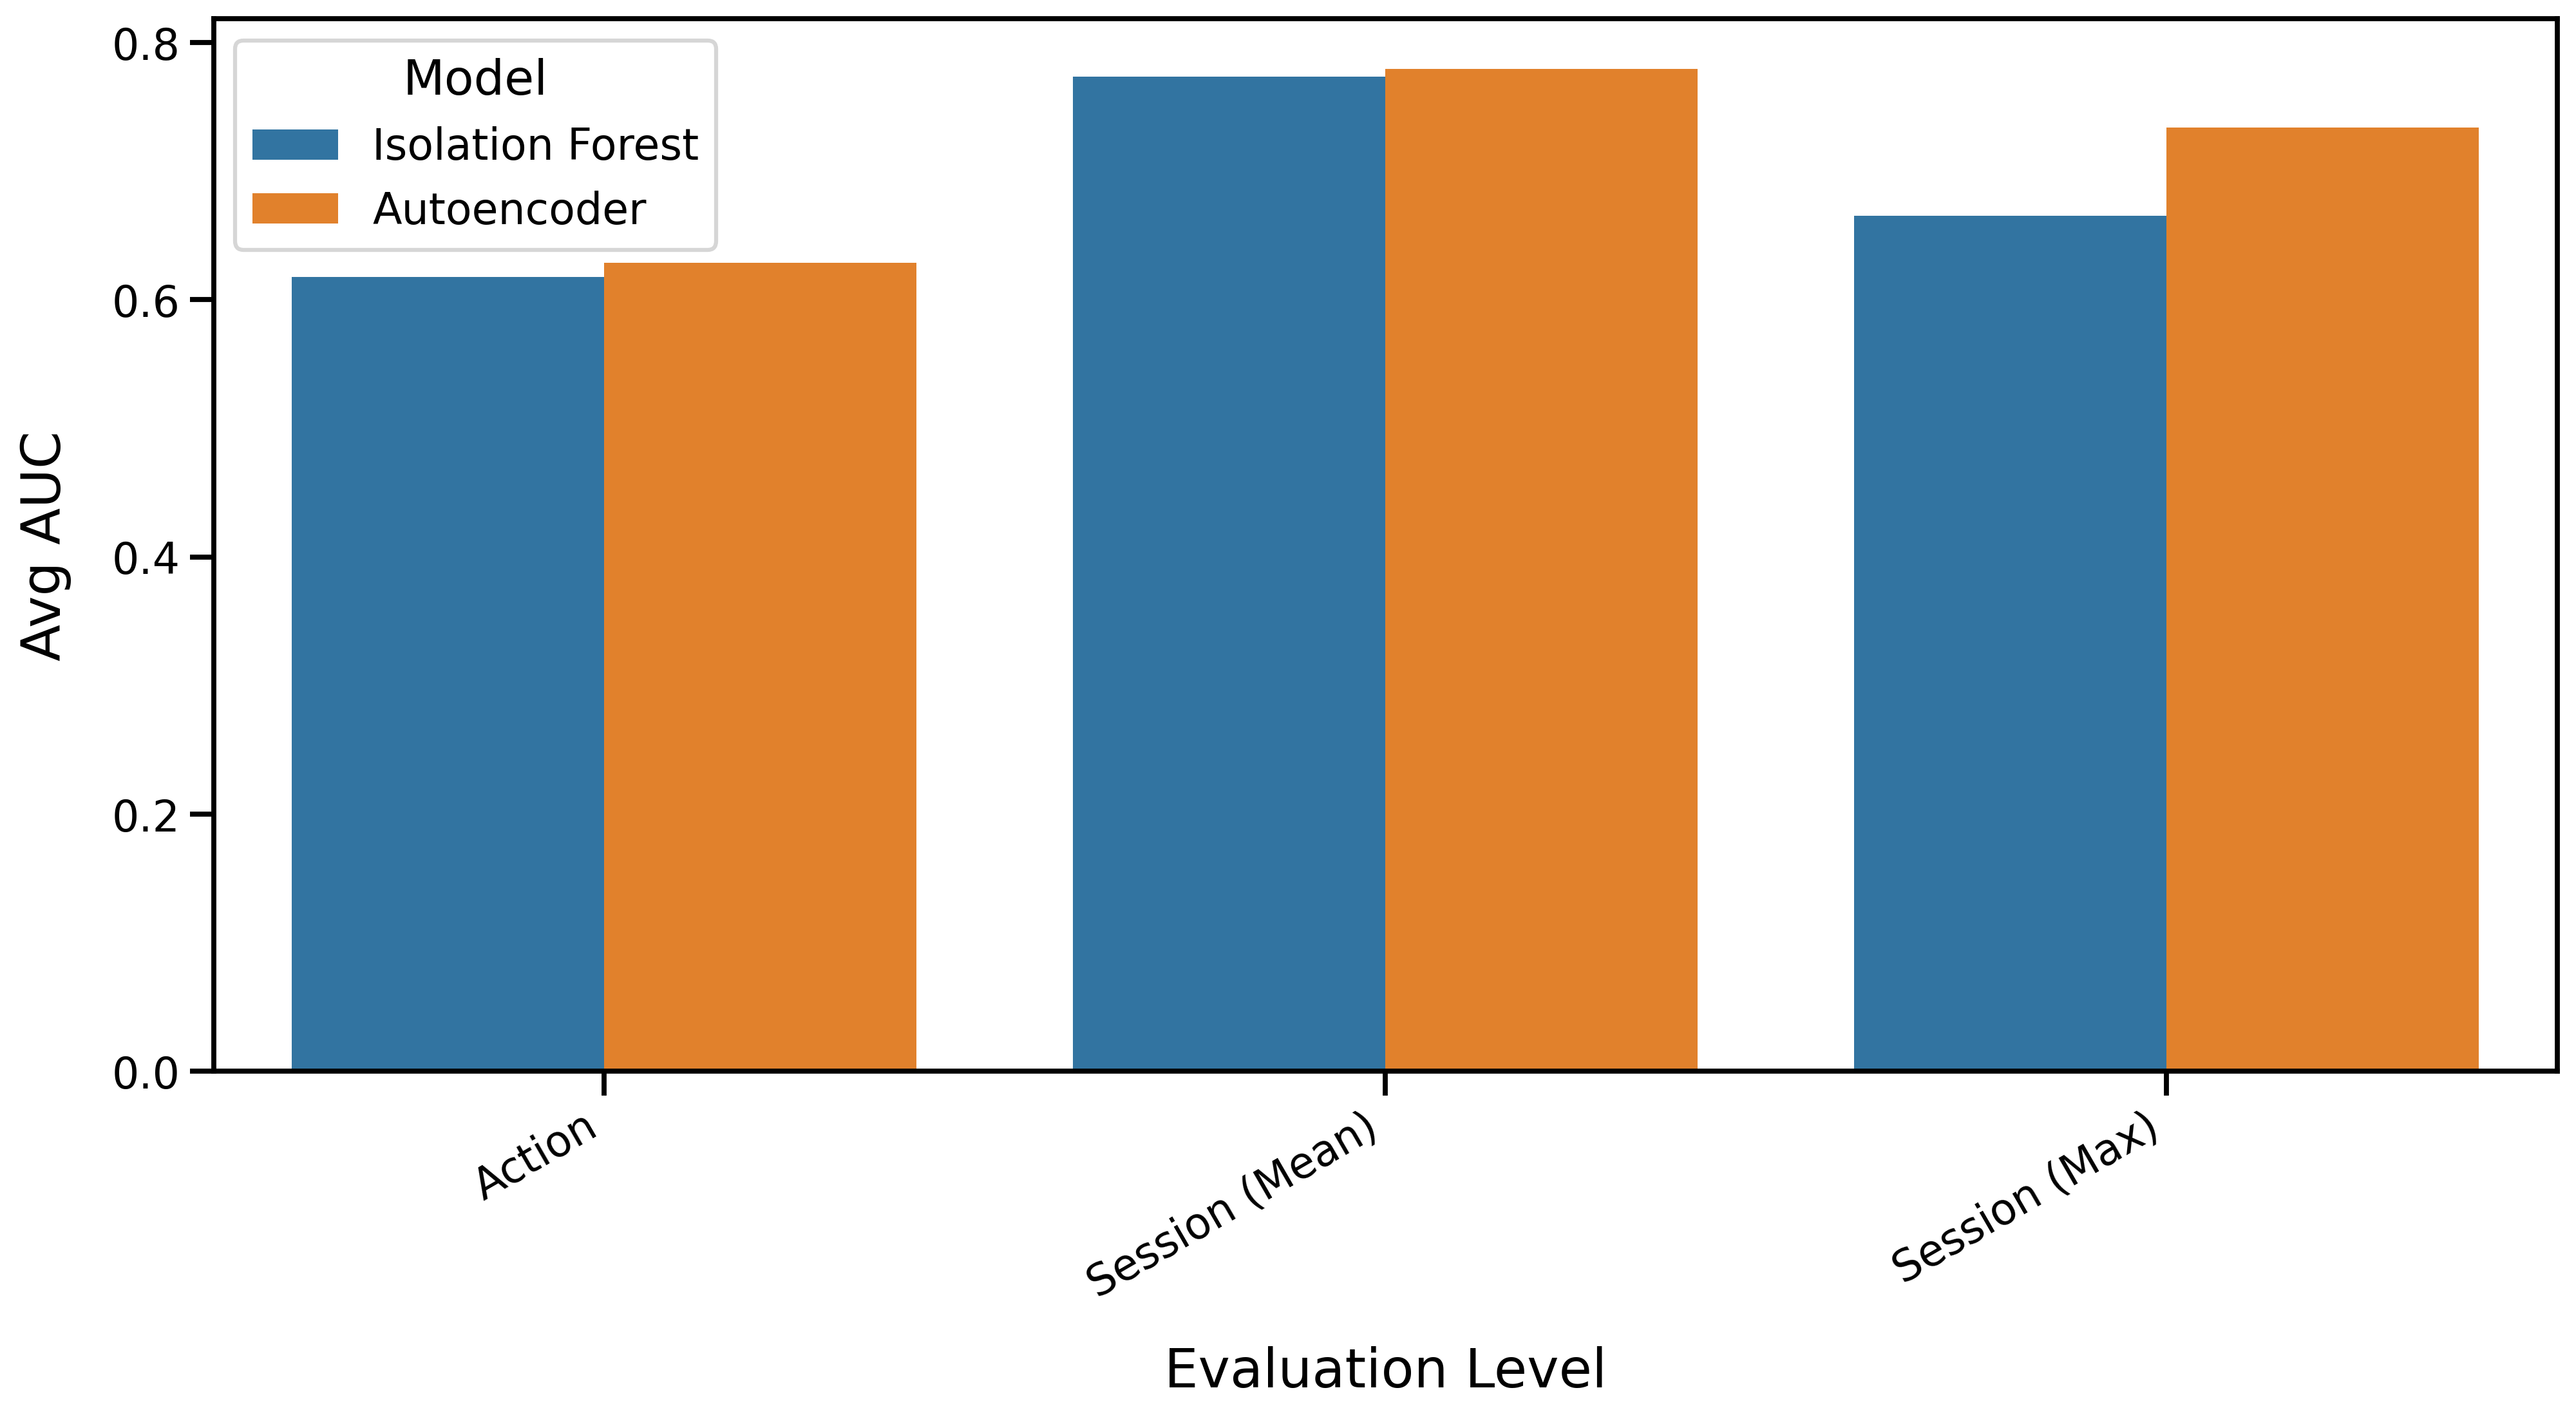

Plot for Avg Recall saved to model_comparison_avg_recall.png


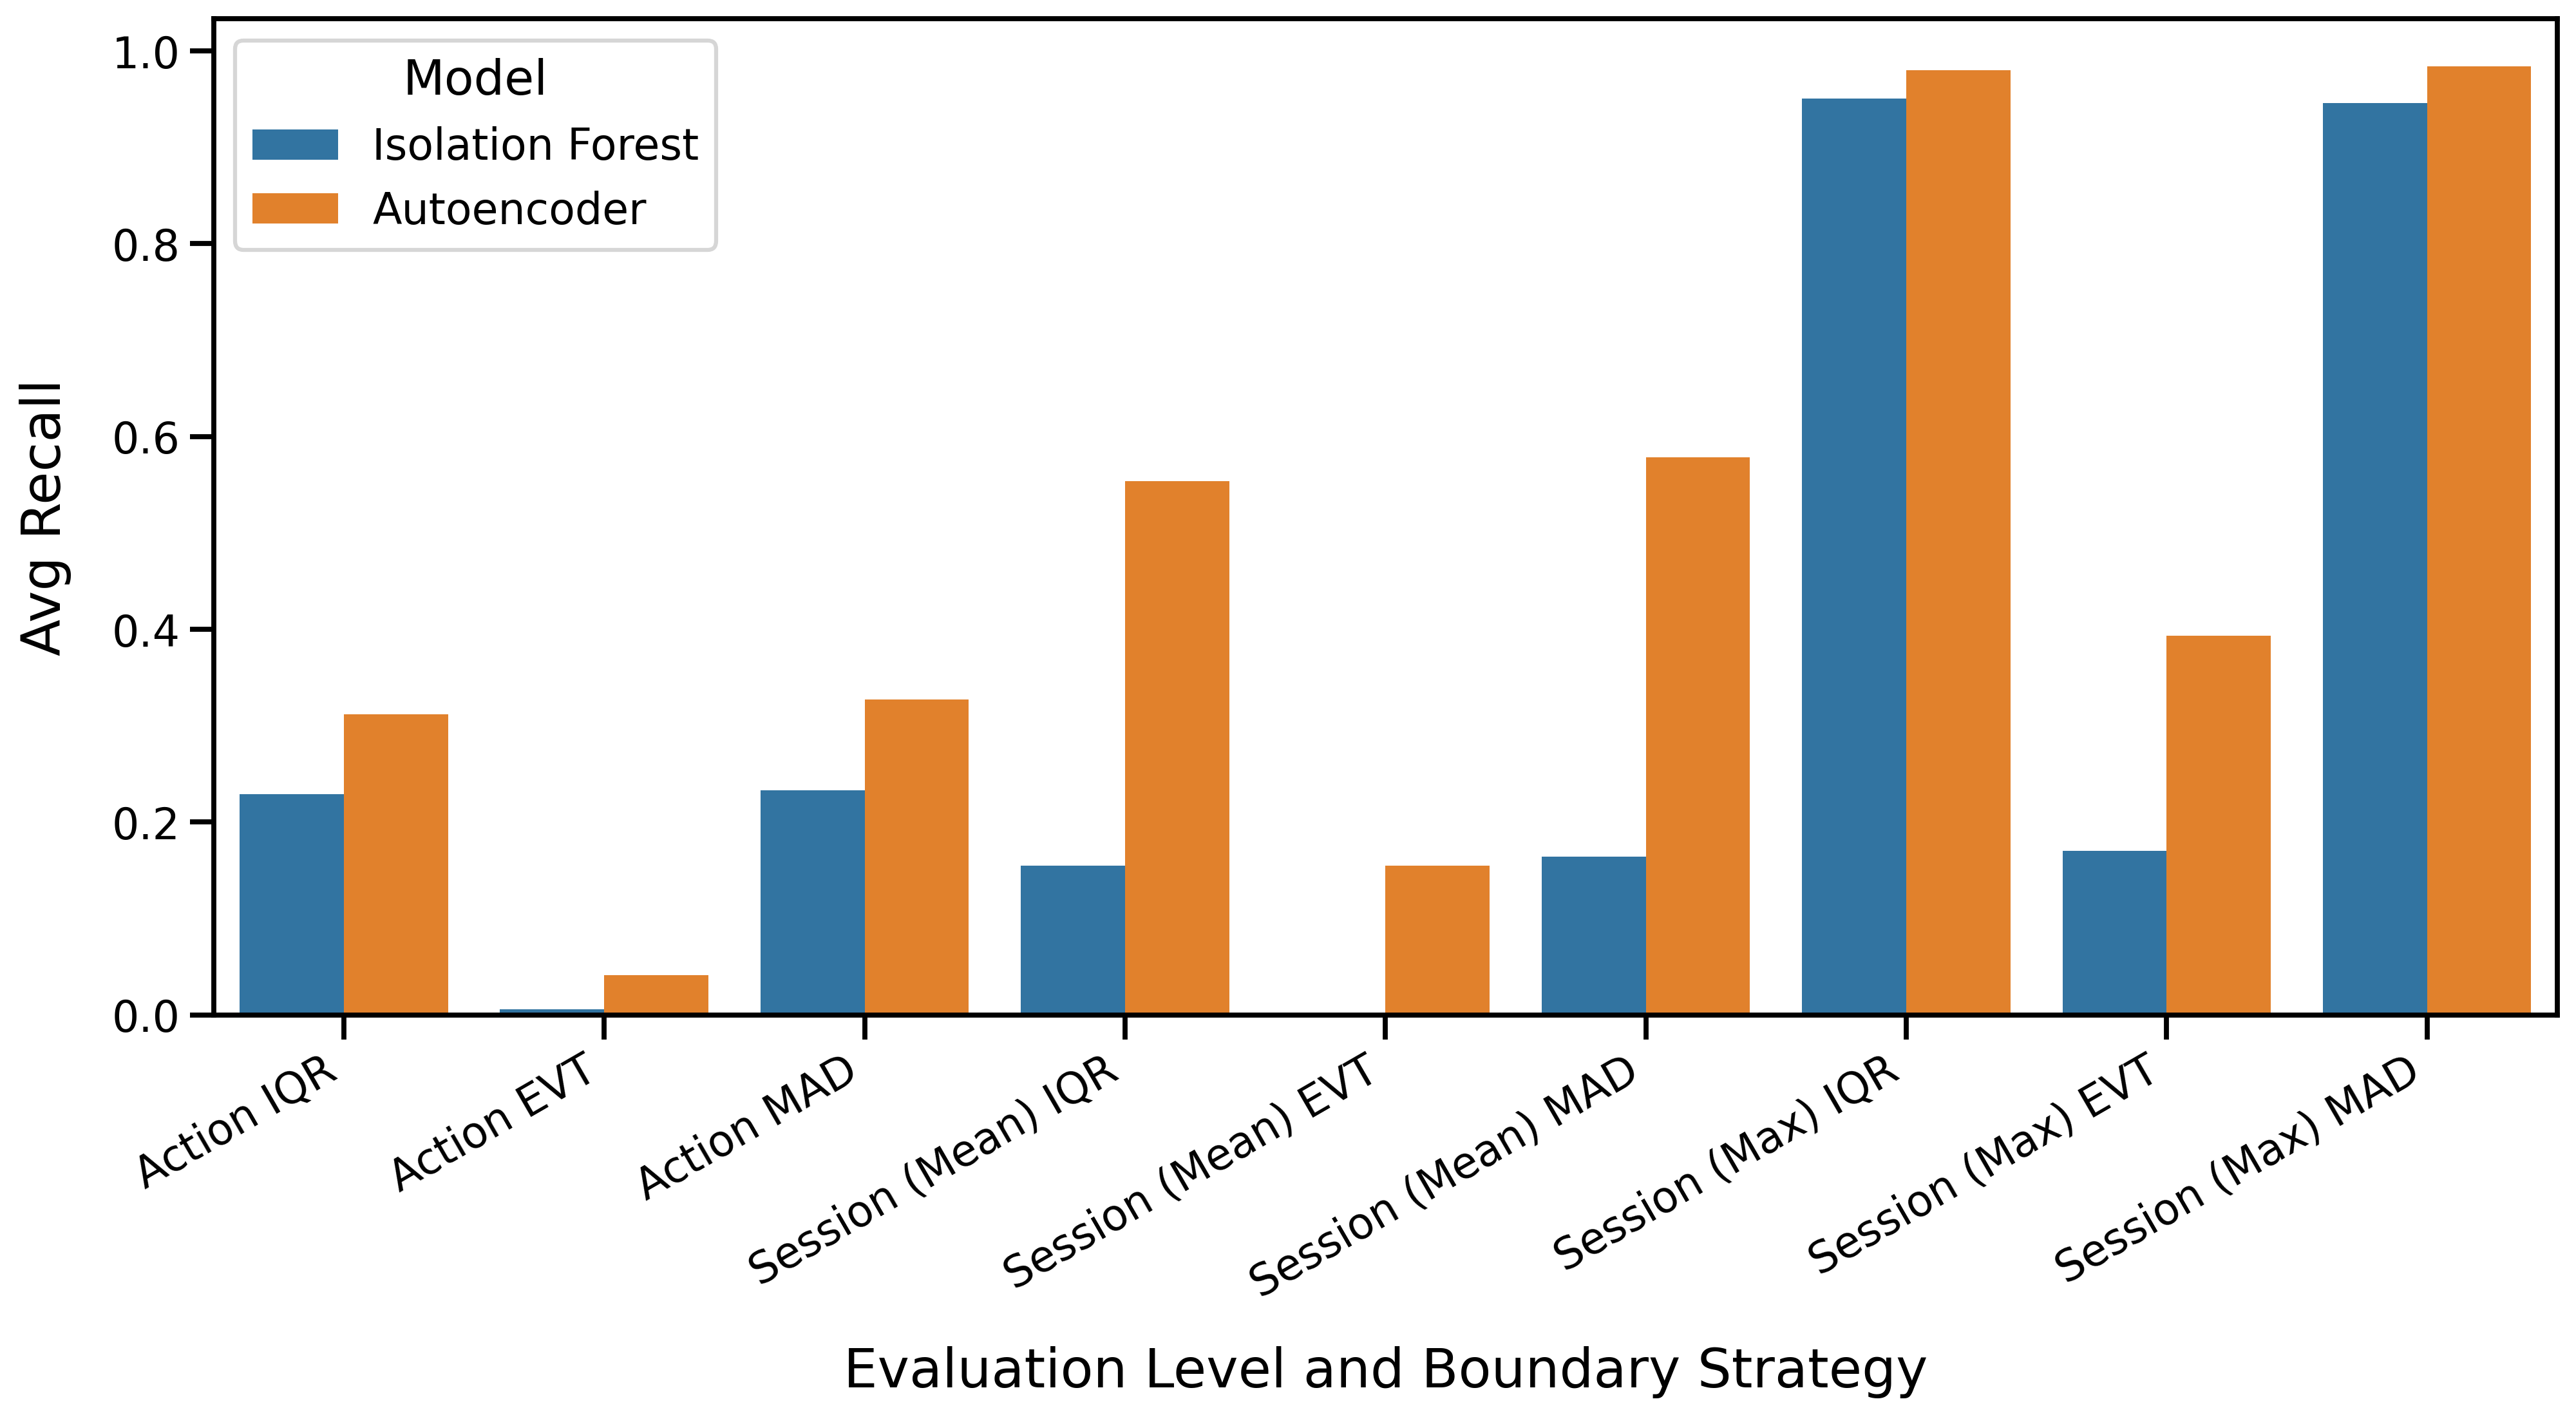

Plot for Avg Precision saved to model_comparison_avg_precision.png


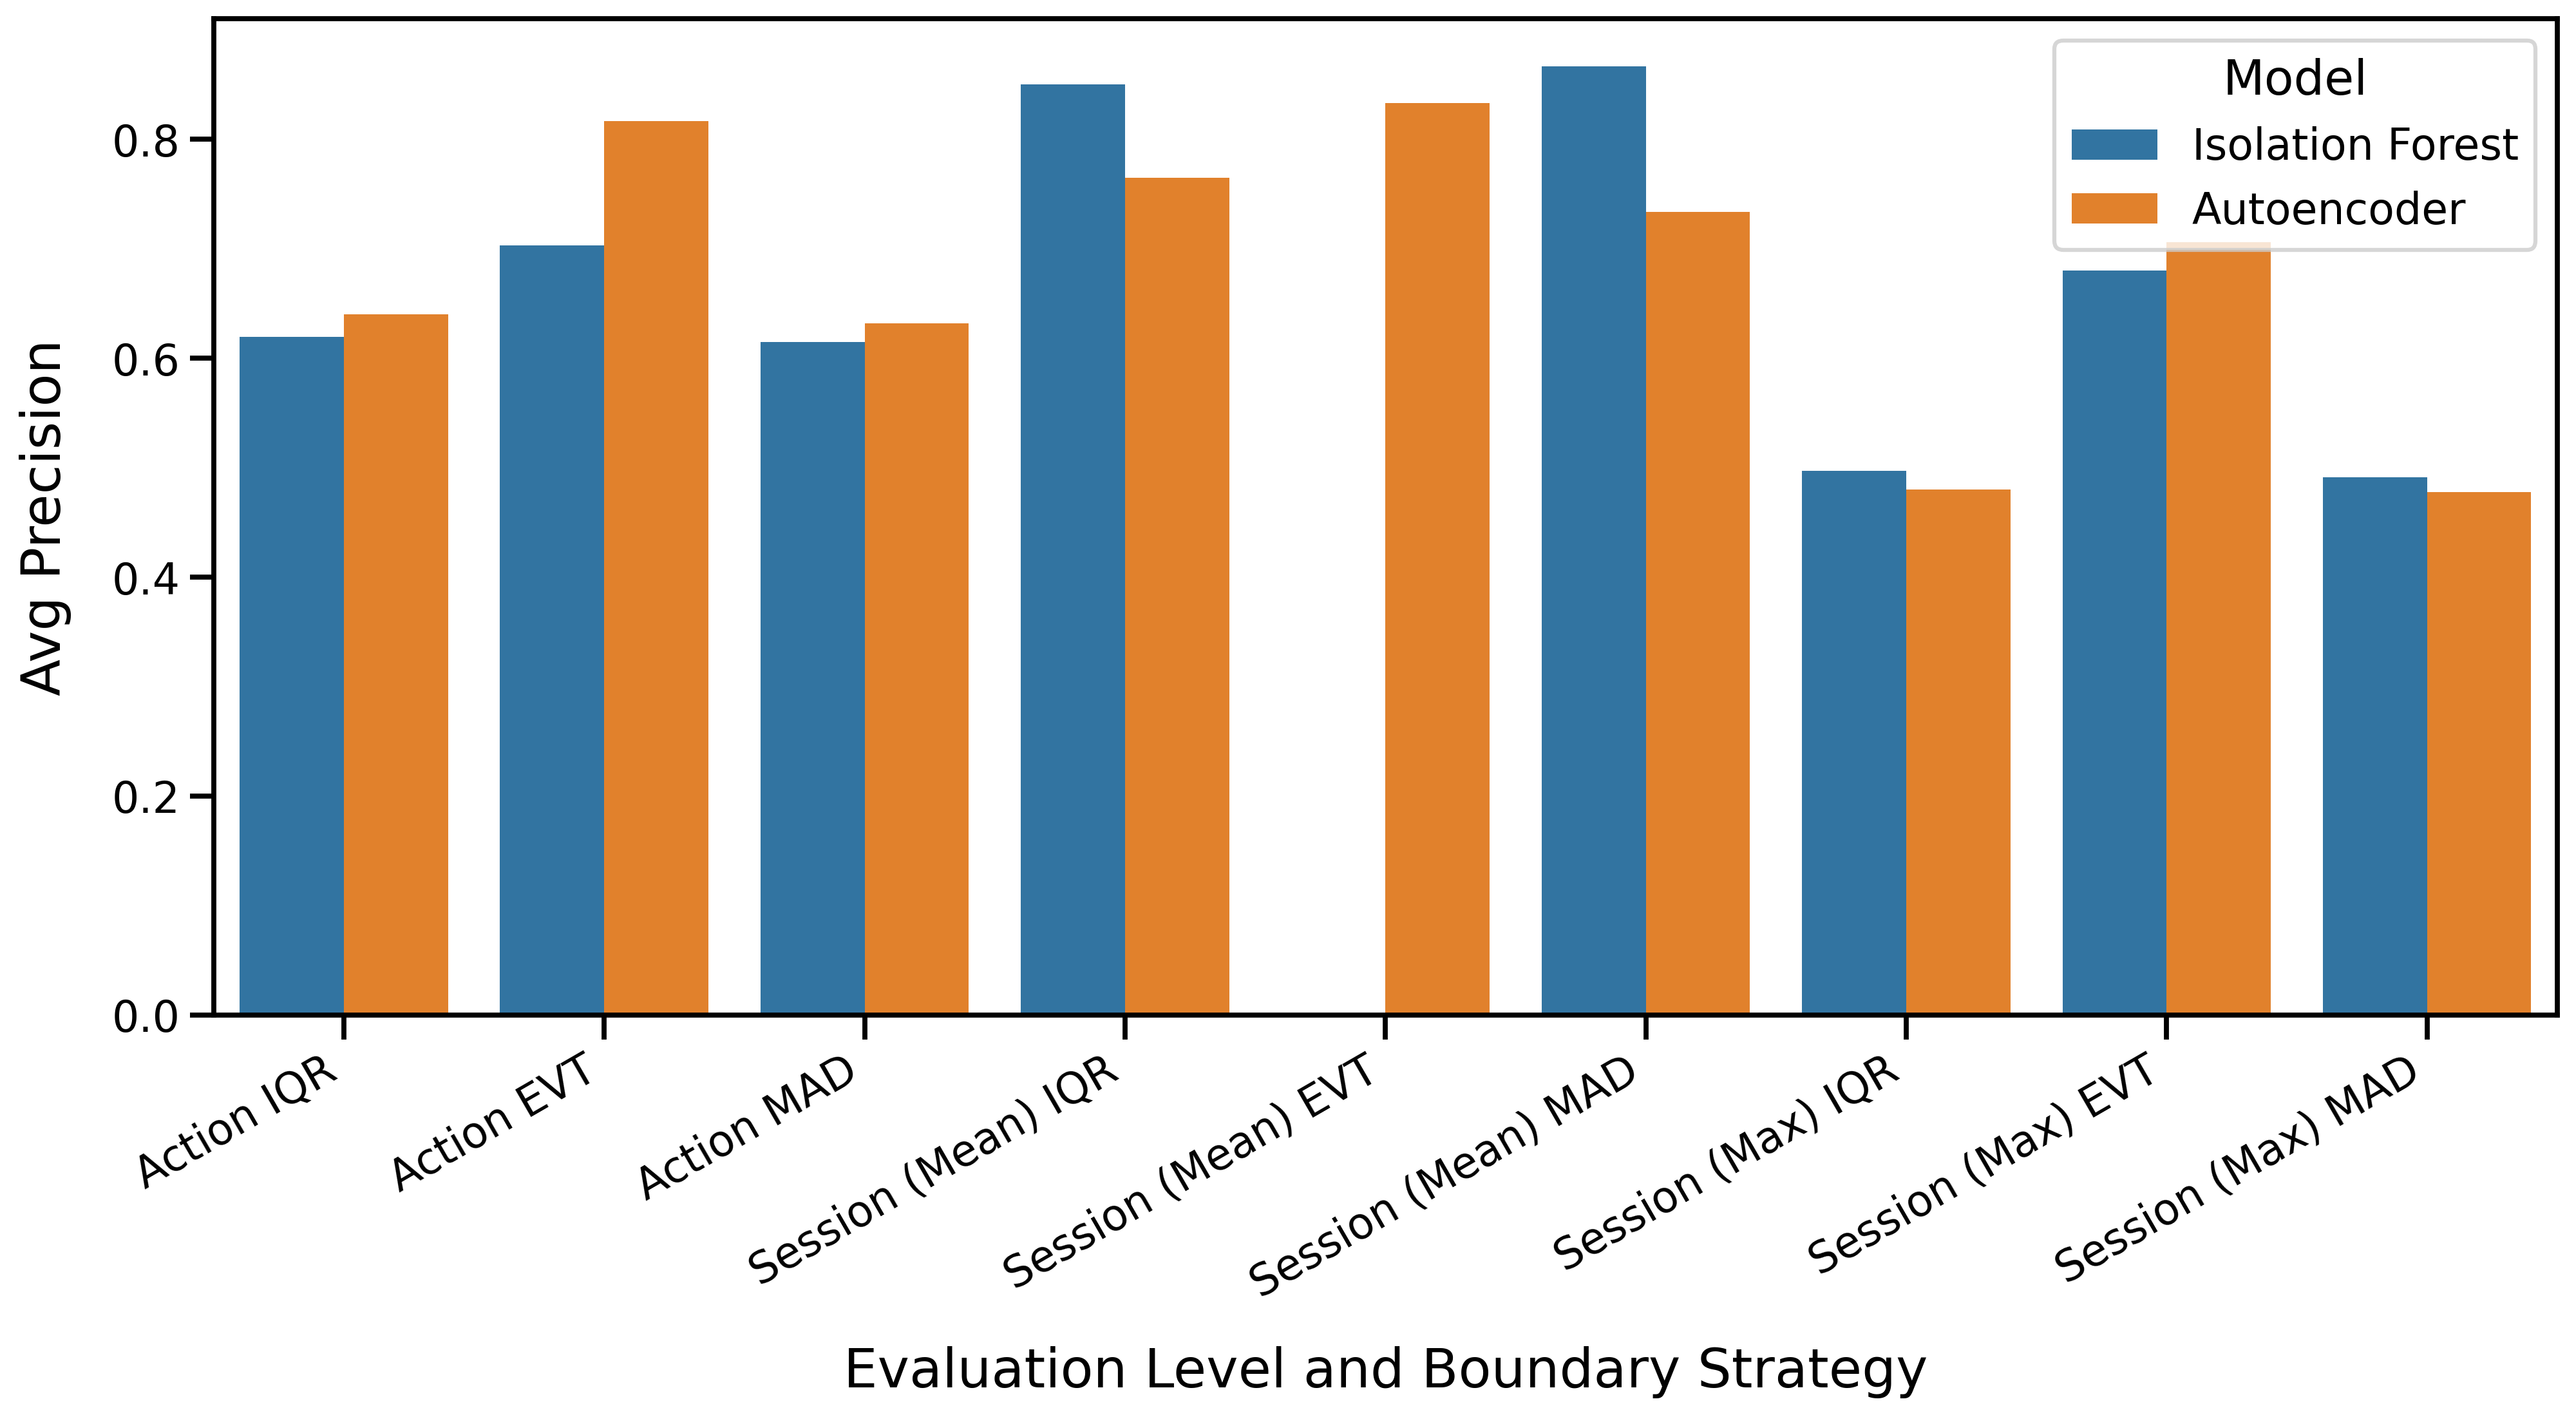

Plot for Avg F1 saved to model_comparison_avg_f1.png


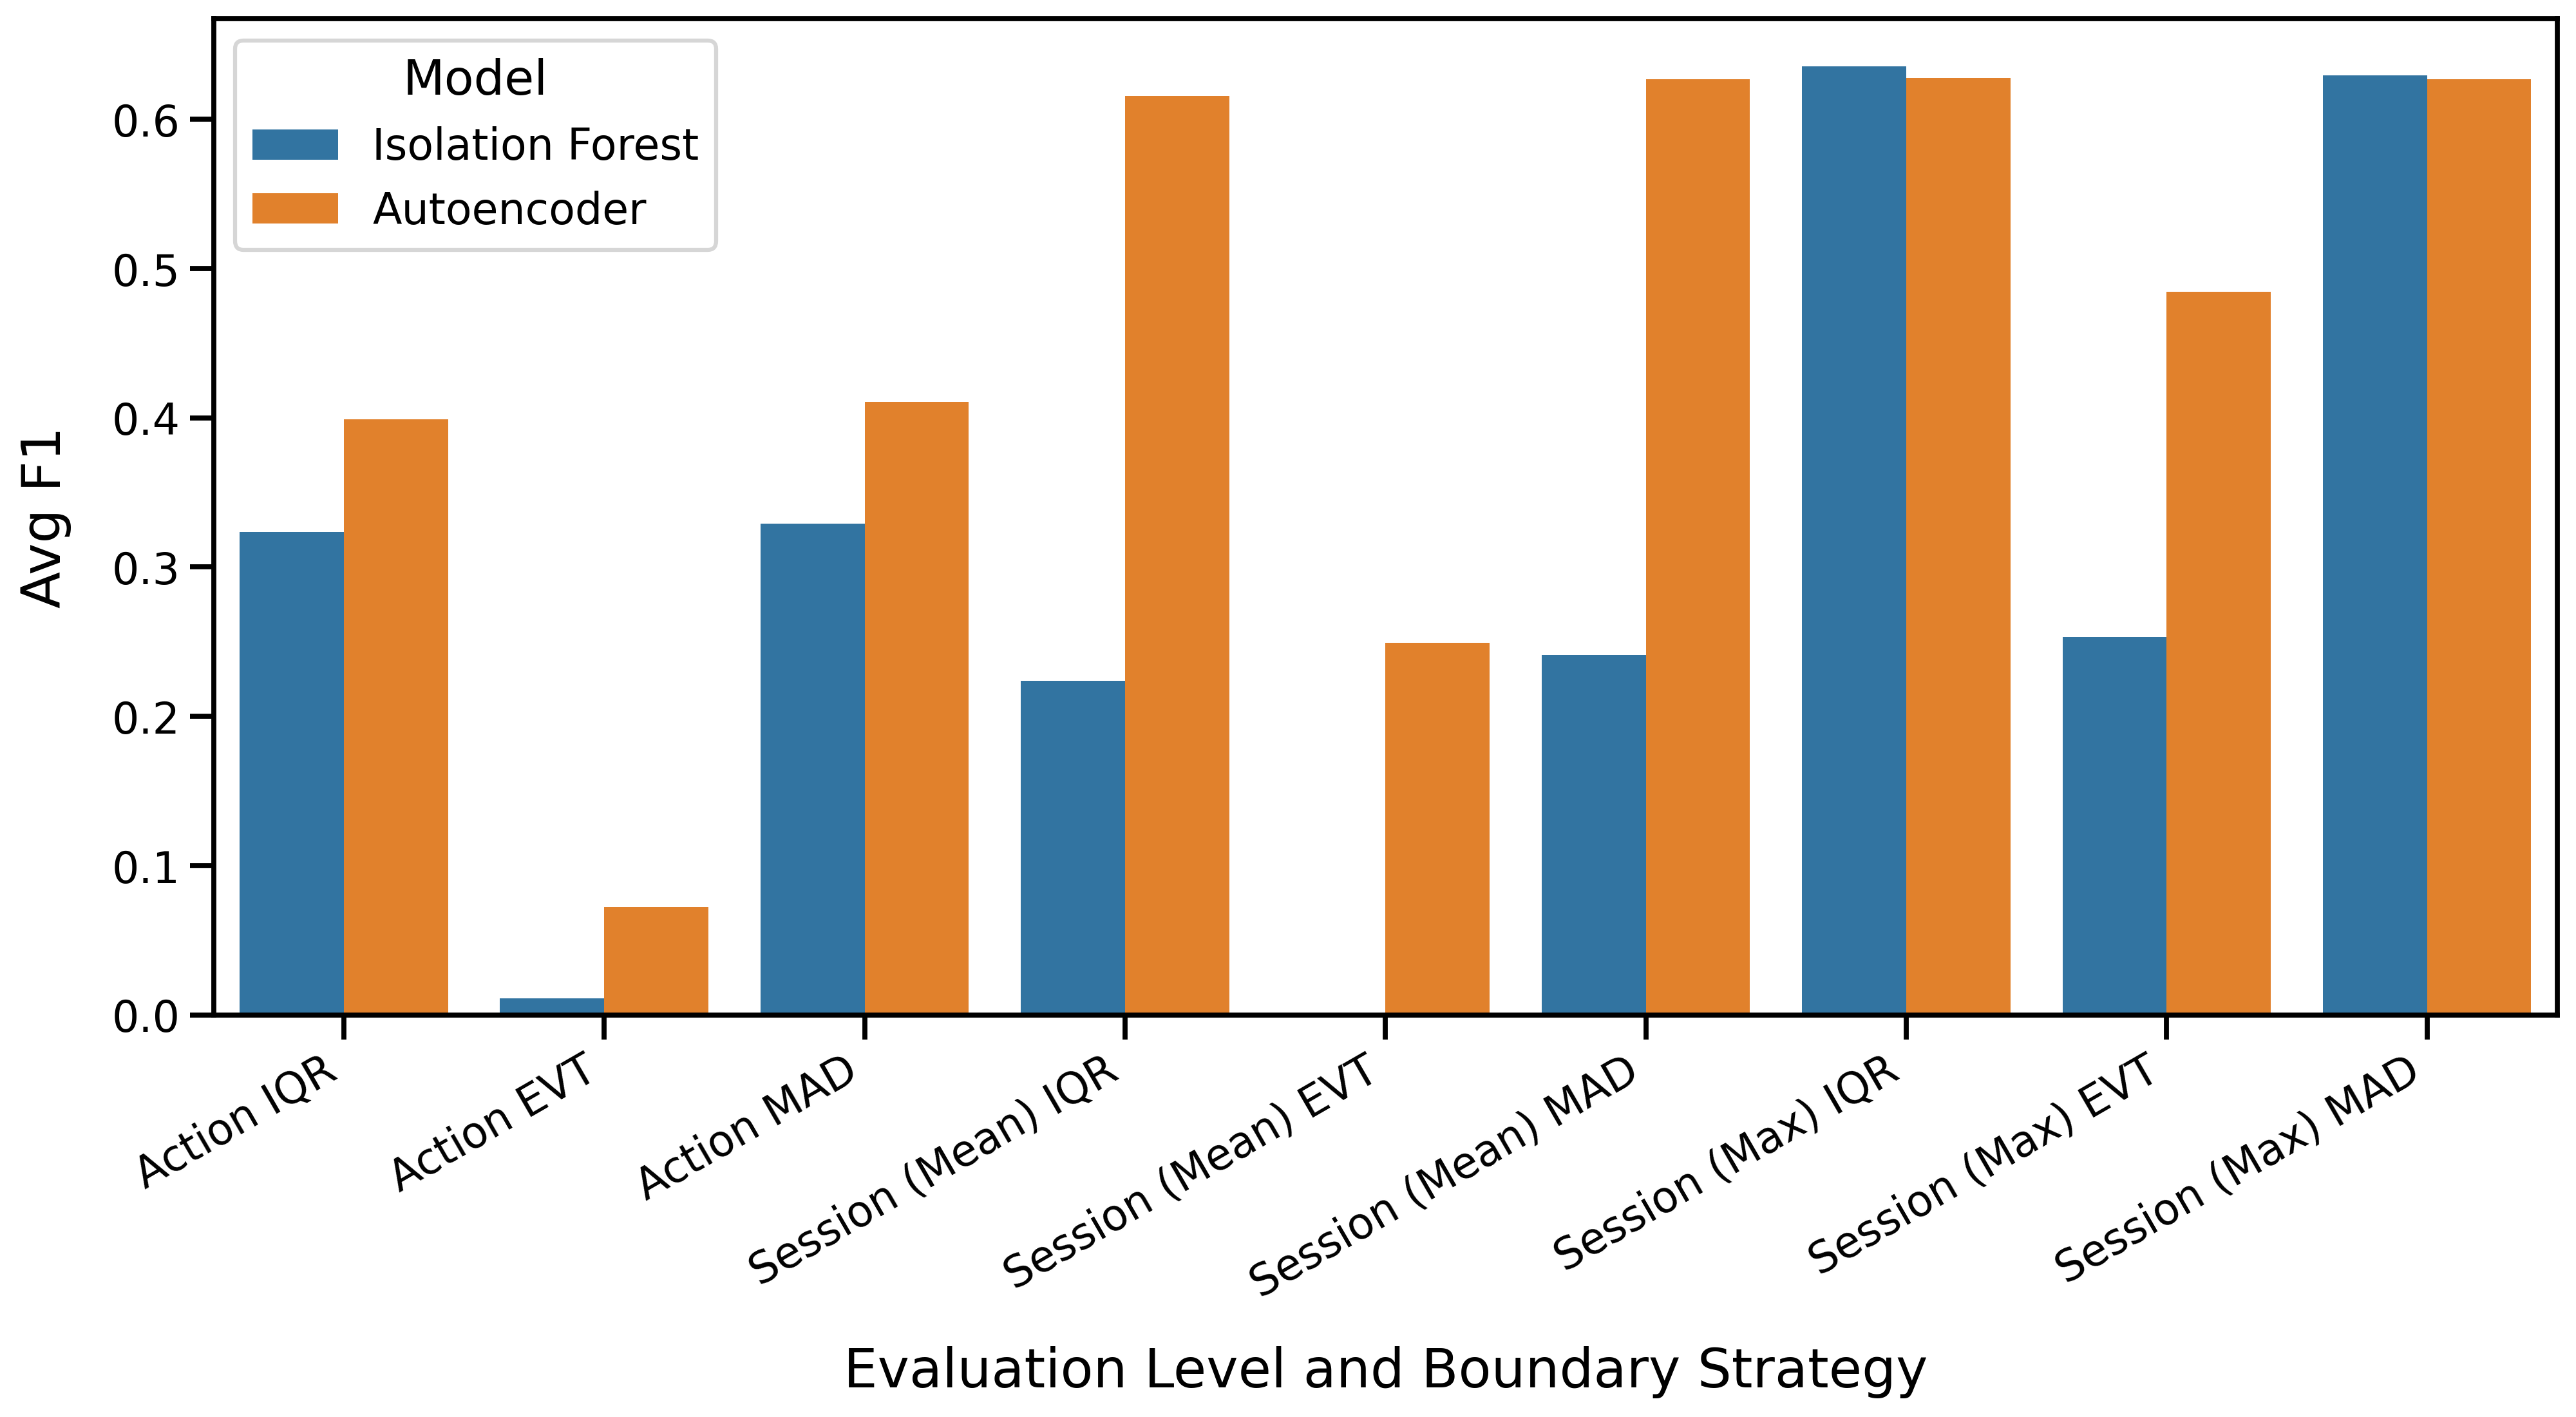

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame with metrics
data = [
    # Isolation Forest: Action-Level
    {'Model': 'Isolation Forest', 'Level': 'Action', 'Method': 'IQR', 'Avg AUC': 0.6176, 'Avg Recall': 0.2287, 'Avg Precision': 0.6195, 'Avg F1': 0.3236},
    {'Model': 'Isolation Forest', 'Level': 'Action', 'Method': 'EVT', 'Avg AUC': 0.6176, 'Avg Recall': 0.0057, 'Avg Precision': 0.7028, 'Avg F1': 0.0112},
    {'Model': 'Isolation Forest', 'Level': 'Action', 'Method': 'MAD', 'Avg AUC': 0.6176, 'Avg Recall': 0.2332, 'Avg Precision': 0.6146, 'Avg F1': 0.3290},
    # Isolation Forest: Session-Level (Mean)
    {'Model': 'Isolation Forest', 'Level': 'Session (Mean)', 'Method': 'IQR', 'Avg AUC': 0.7736, 'Avg Recall': 0.1549, 'Avg Precision': 0.8500, 'Avg F1': 0.2238},
    {'Model': 'Isolation Forest', 'Level': 'Session (Mean)', 'Method': 'EVT', 'Avg AUC': 0.7736, 'Avg Recall': 0.0000, 'Avg Precision': 0.0000, 'Avg F1': 0.0000},
    {'Model': 'Isolation Forest', 'Level': 'Session (Mean)', 'Method': 'MAD', 'Avg AUC': 0.7736, 'Avg Recall': 0.1639, 'Avg Precision': 0.8667, 'Avg F1': 0.2411},
    # Isolation Forest: Session-Level (Max)
    {'Model': 'Isolation Forest', 'Level': 'Session (Max)', 'Method': 'IQR', 'Avg AUC': 0.6651, 'Avg Recall': 0.9505, 'Avg Precision': 0.4969, 'Avg F1': 0.6355},
    {'Model': 'Isolation Forest', 'Level': 'Session (Max)', 'Method': 'EVT', 'Avg AUC': 0.6651, 'Avg Recall': 0.1702, 'Avg Precision': 0.6801, 'Avg F1': 0.2533},
    {'Model': 'Isolation Forest', 'Level': 'Session (Max)', 'Method': 'MAD', 'Avg AUC': 0.6651, 'Avg Recall': 0.9460, 'Avg Precision': 0.4909, 'Avg F1': 0.6294},
    # Autoencoder: Action-Level
    {'Model': 'Autoencoder', 'Level': 'Action', 'Method': 'IQR', 'Avg AUC': 0.6288, 'Avg Recall': 0.3118, 'Avg Precision': 0.6403, 'Avg F1': 0.3989},
    {'Model': 'Autoencoder', 'Level': 'Action', 'Method': 'EVT', 'Avg AUC': 0.6288, 'Avg Recall': 0.0412, 'Avg Precision': 0.8163, 'Avg F1': 0.0724},
    {'Model': 'Autoencoder', 'Level': 'Action', 'Method': 'MAD', 'Avg AUC': 0.6288, 'Avg Recall': 0.3274, 'Avg Precision': 0.6318, 'Avg F1': 0.4107},
    # Autoencoder: Session-Level (Mean)
    {'Model': 'Autoencoder', 'Level': 'Session (Mean)', 'Method': 'IQR', 'Avg AUC': 0.7794, 'Avg Recall': 0.5537, 'Avg Precision': 0.7650, 'Avg F1': 0.6156},
    {'Model': 'Autoencoder', 'Level': 'Session (Mean)', 'Method': 'EVT', 'Avg AUC': 0.7794, 'Avg Recall': 0.1547, 'Avg Precision': 0.8333, 'Avg F1': 0.2491},
    {'Model': 'Autoencoder', 'Level': 'Session (Mean)', 'Method': 'MAD', 'Avg AUC': 0.7794, 'Avg Recall': 0.5784, 'Avg Precision': 0.7334, 'Avg F1': 0.6266},
    # Autoencoder: Session-Level (Max)
    {'Model': 'Autoencoder', 'Level': 'Session (Max)', 'Method': 'IQR', 'Avg AUC': 0.7336, 'Avg Recall': 0.9801, 'Avg Precision': 0.4797, 'Avg F1': 0.6276},
    {'Model': 'Autoencoder', 'Level': 'Session (Max)', 'Method': 'EVT', 'Avg AUC': 0.7336, 'Avg Recall': 0.3935, 'Avg Precision': 0.7060, 'Avg F1': 0.4842},
    {'Model': 'Autoencoder', 'Level': 'Session (Max)', 'Method': 'MAD', 'Avg AUC': 0.7336, 'Avg Recall': 0.9841, 'Avg Precision': 0.4778, 'Avg F1': 0.6268}
]

df_metrics = pd.DataFrame(data)

# Global style with larger fonts
sns.set_context("talk", font_scale=1.6)  # scales everything: labels, ticks, legend

def plot_model_comparison_separate(df_metrics, save_path_prefix=None):
    metrics = ['Avg AUC', 'Avg Recall', 'Avg Precision', 'Avg F1']
    # Removed titles since LaTeX captions will cover that

    for metric in metrics:
        plt.figure(figsize=(14, 8), dpi=300)
        if metric == 'Avg AUC':
            sns.barplot(
                data=df_metrics.drop_duplicates(subset=['Model', 'Level']),
                x='Level', y=metric, hue='Model'
            )
        else:
            df_metrics['Level_Method'] = df_metrics['Level'] + ' ' + df_metrics['Method']
            sns.barplot(
                data=df_metrics, x='Level_Method', y=metric, hue='Model'
            )

        # Removed plt.title()
        plt.xlabel(
            'Evaluation Level and Boundary Strategy' if metric != 'Avg AUC' else 'Evaluation Level',
            fontsize=20, labelpad=15
        )
        plt.ylabel(metric, fontsize=20, labelpad=15)
        plt.xticks(rotation=30, ha='right', fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(title='Model', fontsize=16, title_fontsize=18)
        plt.tight_layout()

        if save_path_prefix:
            metric_filename = metric.lower().replace(" ", "_")
            filename = f"{save_path_prefix}_{metric_filename}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Plot for {metric} saved to {filename}")
        plt.show()

# Run the plotting function
plot_model_comparison_separate(df_metrics, save_path_prefix='model_comparison')